<a href="https://colab.research.google.com/github/enockmwizerwa123/Introduction-to-Machine-Learning/blob/main/Titanic_Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install mysql-connector-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.metrics import (
 classification_report,confusion_matrix,accuracy_score,
 fbeta_score,
 make_scorer,
 recall_score,
)


In [3]:
data_train = pd.read_csv("/content/train_Titanic.csv")
data_test = pd.read_csv("/content/test_Titanic.csv")

In [4]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [33]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [34]:
#chech for null values
data_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Let us first visualize the number of survivors and death counts.

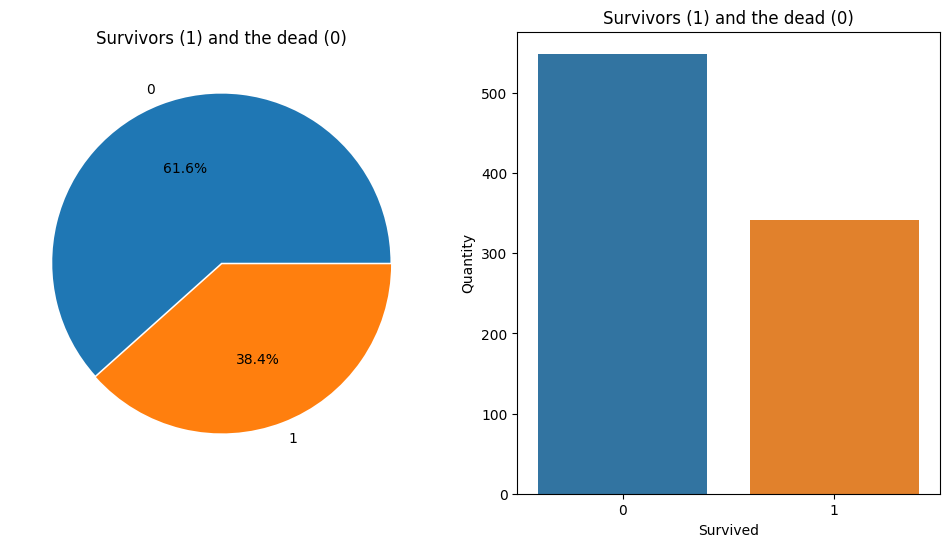

In [6]:
f,ax = plt.subplots(1,2,figsize=(12,6))
data_train['Survived'].value_counts().plot.pie(explode=[0,0.01],autopct ='%1.1f%%',ax=ax[0],shadow=False)
ax[0].set_title('Survivors (1) and the dead (0)')
ax[0].set_ylabel('')
sns.countplot(x='Survived', data=data_train)
ax[1].set_ylabel('Quantity')
ax[1].set_title('Survivors (1) and the dead (0)')
plt.show()

Sex feature

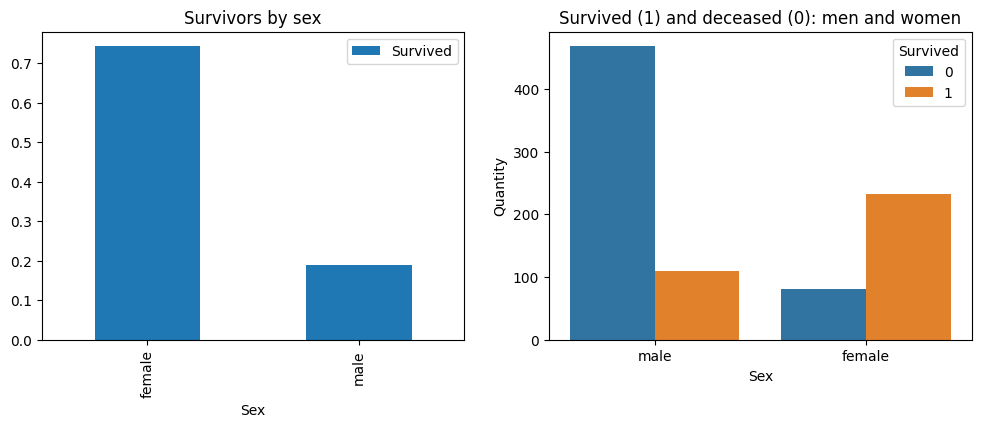

In [36]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
data_train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survivors by sex')
sns.countplot(x = 'Sex', hue='Survived', data=data_train, ax=ax[1])
ax[1].set_ylabel('Quantity')
ax[1].set_title('Survived (1) and deceased (0): men and women')
plt.show();

Feature Engineering

In [37]:
# Create a new column cabinbool indicating
# if the cabin value was given or was NaN
data_train["CabinBool"] = (data_train["Cabin"].notnull().astype('int'))
data_test["CabinBool"] = (data_test["Cabin"].notnull().astype('int'))

# Delete the column 'Cabin' from test
# and train dataset
data_train = data_train.drop(['Cabin'], axis=1)
data_test = data_test.drop(['Cabin'], axis=1)

We can also drop the Ticket feature since it’s unlikely to yield any useful information

In [38]:
data_train = data_train.drop(['Ticket'], axis=1)
data_test = data_test.drop(['Ticket'], axis=1)

There are missing values in the Embarked feature. For that, we will replace the NULL values with ‘S’ as the number of Embarks for ‘S’ are higher than the other two.

In [39]:
# replacing the missing values in
# the Embarked feature with S
data_train = data_train.fillna({"Embarked": "S"})

We will now sort the age into groups. We will combine the age groups of the people and categorize them into the same groups. BY doing so we will be having fewer categories and will have a better prediction since it will be a categorical dataset.

In [40]:
# sort the ages into logical categories
data_train["Age"] = data_train["Age"].fillna(-0.5)
data_test["Age"] = data_test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager',
          'Student', 'Young Adult', 'Adult', 'Senior']
data_train['AgeGroup'] = pd.cut(data_train["Age"], bins, labels=labels)
data_test['AgeGroup'] = pd.cut(data_test["Age"], bins, labels=labels)

In the ‘title’ column for both the test and train set, we will categorize them into an equal number of classes. Then we will assign numerical values to the title for convenience of model training.

In [43]:
from numpy.core.multiarray import datetime_as_string
# create a combined group of both datasets
combine = [data_train, data_test]

# extract a title for each Name in the
# train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(data_train['Title'], data_train['Sex'])

# replace various titles with more common names
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
                                                 'Don', 'Dr', 'Major',
                                                 'Rev', 'Jonkheer', 'Dona'],
                                                'Rare')

    dataset['Title'] = dataset['Title'].replace(
        ['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

data_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

# map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,
                 "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

Now using the title information we can fill in the missing age values.

In [44]:
mr_age = data_train[data_train["Title"] == 1]["AgeGroup"].mode()  # Young Adult
miss_age = data_train[data_train["Title"] == 2]["AgeGroup"].mode()  # Student
mrs_age = data_train[data_train["Title"] == 3]["AgeGroup"].mode()  # Adult
master_age = data_train[data_train["Title"] == 4]["AgeGroup"].mode()  # Baby
royal_age = data_train[data_train["Title"] == 5]["AgeGroup"].mode()  # Adult
rare_age = data_train[data_train["Title"] == 6]["AgeGroup"].mode()  # Adult

age_title_mapping = {1: "Young Adult", 2: "Student",
                     3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

for x in range(len(data_train["AgeGroup"])):
    if data_train["AgeGroup"][x] == "Unknown":
        data_train["AgeGroup"][x] = age_title_mapping[data_train["Title"][x]]

for x in range(len(data_test["AgeGroup"])):
    if data_test["AgeGroup"][x] == "Unknown":
        data_test["AgeGroup"][x] = age_title_mapping[data_test["Title"][x]]

Now assign a numerical value to each age category. Once we have mapped the age into different categories we do not need the age feature. Hence drop it

In [45]:
# map each Age value to a numerical value
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3,
               'Student': 4, 'Young Adult': 5, 'Adult': 6,
               'Senior': 7}
data_train['AgeGroup'] = data_train['AgeGroup'].map(age_mapping)
data_test['AgeGroup'] = data_test['AgeGroup'].map(age_mapping)

data_train.head()

# dropping the Age feature for now, might change
train = data_train.drop(['Age'], axis=1)
test = data_test.drop(['Age'], axis=1)

Drop the name feature since it contains no more useful information.

In [46]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

Assign numerical values to sex and embarks categories\

In [47]:
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

Fill in the missing Fare value in the test set based on the mean fare for that P-class

In [48]:
for x in range(len(test["Fare"])):
    if pd.isnull(test["Fare"][x]):
        pclass = test["Pclass"][x]  # Pclass = 3
        test["Fare"][x] = round(
            train[train["Pclass"] == pclass]["Fare"].mean(), 4)

# map Fare values into groups of
# numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4,
                            labels=[1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4,
                           labels=[1, 2, 3, 4])

# drop Fare values
train = train.drop(['Fare'], axis=1)
test = test.drop(['Fare'], axis=1)

**Model Training**


We will be using Random forest as the algorithm of choice to perform model training. Before that, we will split the data in an 80:20 ratio as a train-test split. For that, we will use the train_test_split() from the sklearn library.

In [49]:
# Drop the Survived and PassengerId
# column from the trainset
predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train["Survived"]
x_train, x_val, y_train, y_val = train_test_split(
    predictors, target, test_size=0.2, random_state=0)

In [50]:
randomforest = RandomForestClassifier()

# Fit the training data along with its output
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)

# Find the accuracy score of the model
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

85.47


**Prediction**


We are provided with the testing dataset on which we have to perform the prediction. To predict, we will pass the test dataset into our trained model and save it into a CSV file containing the information, passengerid and survival. PassengerId will be the passengerid of the passengers in the test data and the survival will column will be either 0 or 1.

In [51]:
ids = test['PassengerId']
predictions = randomforest.predict(test.drop('PassengerId', axis=1))

# set the output as a dataframe and convert
# to csv file named resultfile.csv
output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions})
output.to_csv('resultfile.csv', index=False)